In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from contact_graspnet.dataloading import OrigExampleData, YCBSimulationData
from contact_graspnet.preprocessing import Img2CamCoords, Depth2ImgPoints, ZClipper, UniversalPreprocessor, SegmentationBinarizer, Resizer
from contact_graspnet.postprocessing import Postprocessor, TopScoreFilter, Cam2WorldGraspConverter, Cam2WorldCoordConverter
from contact_graspnet.models import ContactGraspnet
from contact_graspnet.utils import visualization as vis
from contact_graspnet.utils.misc import get_root_dir, setup_tensorflow

2023-03-07 14:13:52.667788: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 14:13:55.367633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/moritz/catkin_ws/devel/lib:/opt/ros/noetic/lib:/home/moritz/.mujoco/mujoco210/bin:/home/moritz/mambaforge/envs/contact/lib/:/home/moritz/mambaforge/envs/contact/lib/
2023-03-07 14:13:55.367893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No

/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/tf_ops/sampling


In [2]:
setup_tensorflow()

In [3]:
# dataset = OrigExampleData(
#     get_root_dir() / "data" / "raw" / "orig_test_data",
#     transform=UniversalPreprocessor(
#         depth2points_converter=Depth2ImgPoints(),
#         img2cam_converter=Img2CamCoords(),
#         z_clipper=ZClipper([0.2, 1.8]),
#         segmentation_binarizer=SegmentationBinarizer(2.0),
#     ),
# )

dataset = YCBSimulationData(
    Path.home() / "Documents" / "ycb_sim_data_1",
    transform=UniversalPreprocessor(
        depth2points_converter=Depth2ImgPoints(),
        img2cam_converter=Img2CamCoords(),
        z_clipper=ZClipper([0.2, 1.8]),
        # segmentation_binarizer=SegmentationBinarizer(),
    ),
)

001_master_chef_can


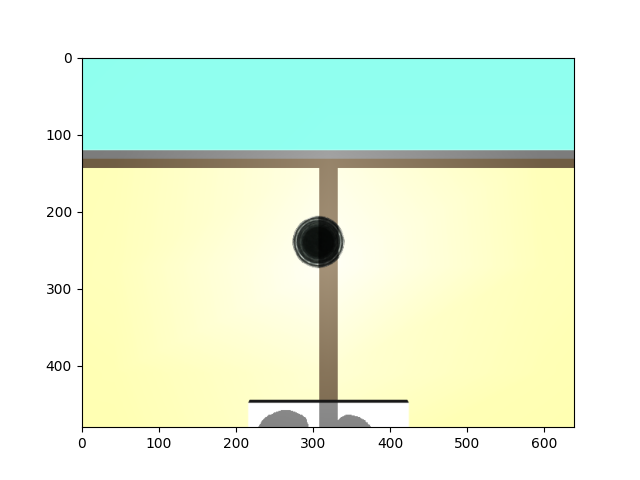

In [4]:
full_pc, segmented_pc = dataset[0]

sample = dataset.transform.intermediate_results["initial_sample"]
print(sample.name)
plt.imshow(sample.rgb)

In [5]:
model = ContactGraspnet(
    get_root_dir()
    / "checkpoints"
    / "scene_test_2048_bs3_hor_sigma_001"
    / "config.yaml",
    get_root_dir() / "checkpoints" / "scene_test_2048_bs3_hor_sigma_001",
)

--- Get model


/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/orig/pointnet2/utils/tf_util.py:569: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.compat.v1.layers.batch_normalization(


('loading ', '/home/moritz/Documents/ContactGraspnetBenchmark/contact_graspnet/checkpoints/scene_test_2048_bs3_hor_sigma_001/model.ckpt-54054')


In [6]:
postprocessor = Postprocessor(top_score_filter=None)

In [7]:
network_output = (pred_grasps_cam, scores, contact_pts, widths) = model(full_pc, segmented_pc)

grasps_sim_cam = postprocessor(network_output)

Extracted Region Cube Size:  0.3
Generated 52 grasps for object -1


In [8]:
full_pc_colors = dataset.transform.intermediate_results["full_pc_colors"]

# vis.mlab_pose_vis(
#     full_pc,
#     [max(postprocessor.intermediate_results["all_grasps_paper"], key=lambda g: g.score)],
#     full_pc_colors,
# )

# mlab_pose_vis(
#     segmented_pc,
#     postprocessor.intermediate_results["all_grasps_paper"],
#     preprocessor.intermediate_results["segmented_pc_colors"],
# )

In [9]:
best_grasp_sim_cam = max(grasps_sim_cam, key=lambda g: g.score)

In [10]:
cam2world = Cam2WorldGraspConverter()

best_grasp_world = cam2world(best_grasp_sim_cam, sample.cam_pos, sample.cam_rot)

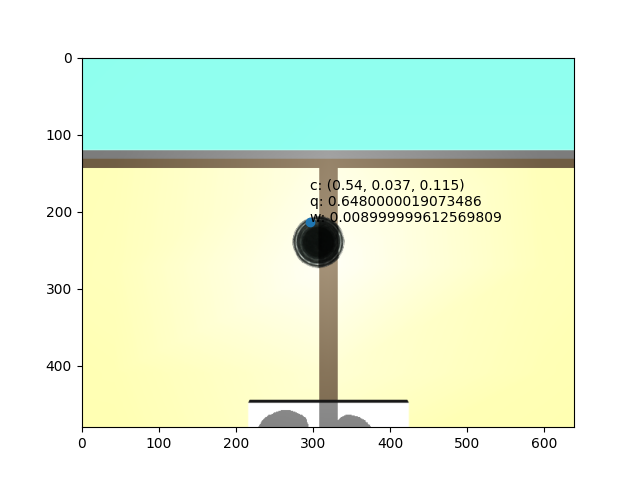

In [11]:
fig, ax = plt.subplots()

vis.world_grasps_center_ax(ax, sample.rgb, [best_grasp_world], sample.cam_intrinsics, sample.cam_rot, sample.cam_pos)

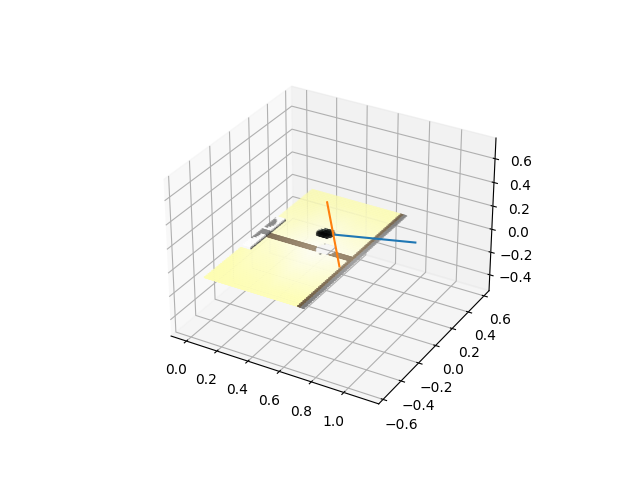

In [12]:
N = 10

cam2world_coord = Cam2WorldCoordConverter()
pc_world = np.array([cam2world_coord(p, sample.cam_pos, sample.cam_rot) for p in full_pc[::N]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d', computed_zorder=False)

vis.grasp6D_ax(ax, best_grasp_world, pc_world, full_pc_colors[::N])
vis.set_axes_equal(ax)

In [13]:
vis.mlab_pose_vis(
    full_pc,
    [max(postprocessor.intermediate_results["all_grasps_paper"], key=lambda g: g.score)],
    full_pc_colors,
)

In [14]:
# cam2world_coord = Cam2WorldCoordConverter()

# pc_world = np.array([cam2world_coord(p, sample.cam_pos, sample.cam_rot) for p in full_pc[::100]])

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# # ax.set_box_aspect([1,1,1])
  
# ax.scatter(pc_world[:, 0], pc_world[:, 1], pc_world[:, 2])# , c=dataset.transform.intermediate_results["full_pc_colors"])
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.scatter(best_grasp_world.position[0], best_grasp_world.position[1], best_grasp_world.position[2], c="r", s=100)

# plt.show()